<div style="padding: 20px"> <h1 style="color:black; margin-bottom:20px">Анализ и разработка стратегии взаимодействия с клиентами для сети фитнес-центров «Культурист-датасаентист».</h1>

<b>Запрос от бизнеса:</b> провести анализ и подготовить план действий по удержанию клиентов, уменьшить их отток. 
А именно:
1. научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
+ сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
+ проанализировать основные признаки, наиболее сильно влияющие на отток;
+ сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

    -  выделить целевые группы клиентов;
    -  предложить меры по снижению оттока;
    -  определить другие особенности взаимодействия с клиентами.

<b> Содержание:</b>
1. [Получение и изучение данных](##step1) 
2. [Исследовательский анализ данных (EDA)](##step2)
3. [Модель прогнозирования оттока клиентов](##step3)
4. [Кластеризация клиентов](##step4)
4. [Выводы и рекомендации по работе с клиентами](##step5)

<a id='#step1'></a> 
### Получение и изучение данных

<b>Исходные данные представляют собой следующую информацию:</b>

- 'Churn' — факт оттока в текущем месяце;

Данные клиента за предыдущий до проверки факта оттока месяц:
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба;
- 'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга»;
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

In [1]:
#библиотеки
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
import matplotlib.pyplot as plt
import re

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv', sep=',')
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
#приведем все заголовки к нижнему регистру
df.columns = df.columns.str.lower()
df.head(2)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0


In [4]:
#переименуем некоторые столбцы для отображения в ширину страницы
df.rename(columns = {"near_location":"loc","promo_friends":"friends","contract_period":"contr_length", "group_visits":"gr_vis",
                    "avg_additional_charges_total":"service","month_to_end_contract":"m_to_end_contr",
                     "avg_class_frequency_total":"avg_vis/week_total", "avg_class_frequency_current_month":"avg_vis/week_cur_month"},inplace = True)
df.head(2)

,gender,loc,partner,friends,phone,contr_length,gr_vis,age,service,m_to_end_contr,lifetime,avg_vis/week_total,avg_vis/week_cur_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0


Так данные легче читать. Можно приступать к их исследованию.

<a id='#step2'></a> 
### Исследовательский анализ данных (EDA)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                    4000 non-null int64
loc                       4000 non-null int64
partner                   4000 non-null int64
friends                   4000 non-null int64
phone                     4000 non-null int64
contr_length              4000 non-null int64
gr_vis                    4000 non-null int64
age                       4000 non-null int64
service                   4000 non-null float64
m_to_end_contr            4000 non-null float64
lifetime                  4000 non-null int64
avg_vis/week_total        4000 non-null float64
avg_vis/week_cur_month    4000 non-null float64
churn                     4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Пропусков нет. Все столбцы числовые - целочисленные или с плавающей точкой. Проверим дубликаты и удалим их.

In [6]:
len(df.duplicated())

4000

In [7]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                    4000 non-null int64
loc                       4000 non-null int64
partner                   4000 non-null int64
friends                   4000 non-null int64
phone                     4000 non-null int64
contr_length              4000 non-null int64
gr_vis                    4000 non-null int64
age                       4000 non-null int64
service                   4000 non-null float64
m_to_end_contr            4000 non-null float64
lifetime                  4000 non-null int64
avg_vis/week_total        4000 non-null float64
avg_vis/week_cur_month    4000 non-null float64
churn                     4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 468.8 KB


In [8]:
# процентиль список
perc =[.10,.20, .30, .40, .60, .70,.80, .90]
df.describe(percentiles = perc).T

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
loc,4000.0,0.845250,0.361711,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
contr_length,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,6.000000,12.000000,12.000000,12.000000
gr_vis,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,25.000000,26.000000,27.000000,28.000000,29.000000,30.000000,31.000000,32.000000,33.000000,41.000000
service,4000.0,146.943728,96.355602,0.148205,27.290435,55.796873,83.540860,109.333272,136.220159,163.152487,194.067852,229.163952,277.717199,552.590740
m_to_end_contr,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,6.000000,9.000000,12.000000,12.000000


Текущий вывод: 
- большинство клиентов живет рядом с клубом
- мужчин и женщин примерно одинаковое количество.
- порядка 40% клиентов пришли по парнтнерской программе - сотрудники компаний-партнеров
- порядка 30% климентов пришли по рекомендации друзей
- больше половины клиентов берут абонемент на месяц, и лишь около 20% на год
- груповые занятия посещает менее половины клиентов - порядка 40% (это может объясняться полом клиентов, т.к. женщины чаще ходят на групповые занятия, а мужчины в тренажерный зал)
- возраст целевой аудитории от 25 до 33 лет
- более 60% клиентов тратят в сумме на доп. услуги более 100тыс. рублей, и около 20% - более 200тыс.рублей
- лишь около 20% клиентов посещают клуб от полугода. Я бы даже сказала, что у клуба почти нет постоянных клиентов, которые ходят годами
- средняя частота посещения клуба - 1-2 раза в неделю. При этом заметна тенденция к сокращению количества визитов перед отказом от услуг клуба.
- зафиксированный отток клиентов в текущем месяце приблизительно 20% (если 1-отток, а 0-клиент остался)

В колонке Service подозрительно большое максимальное значение. Проверим в ней выбросы, для этого построим гистограмму.

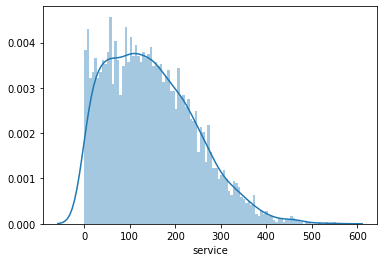

In [9]:
sns.distplot(df['service'], bins=100);

In [10]:
#удалим выбросы
df = df.query('service < 450')
df.shape

(3982, 14)

Удалено 18 строк из 4000, это незначительно количество. Оставим эту корректировку.

In [11]:
#Посмотрим на средние значения признаков в группах тех, кто ушел в отток и тех, кто остался
#те, кто ушел
df_churn = df.query('churn == 1').describe()
df_churn.head(2)

,gender,loc,partner,friends,phone,contr_length,gr_vis,age,service,m_to_end_contr,lifetime,avg_vis/week_total,avg_vis/week_cur_month,churn
count,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.0
mean,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546,1.0


In [12]:
#те, кто остался
df_stay = df.query('churn != 1').describe()
df_stay.head(2)

,gender,loc,partner,friends,phone,contr_length,gr_vis,age,service,m_to_end_contr,lifetime,avg_vis/week_total,avg_vis/week_cur_month,churn
count,2921.000000,2921.000000,2921.000000,2921.000000,2921.0000,2921.000000,2921.000000,2921.000000,2921.000000,2921.000000,2921.000000,2921.000000,2921.000000,2921.0
mean,0.511811,0.874016,0.535091,0.355015,0.9038,5.756248,0.462855,29.979459,156.475817,5.291339,4.711058,2.023566,2.026594,0.0


Сравнивая таблицы видим, что остаются чаще те, кто:
-  ближе живет
-  пришел по партнерской программе или по совету друзей
-  изначально берет более длительный абонемент
-  старше по возрасту
-  приходит от двух раз в неделю

При этом на доп услуги постоянные клиенты также тратятся больше примерно в 1.5 раза.

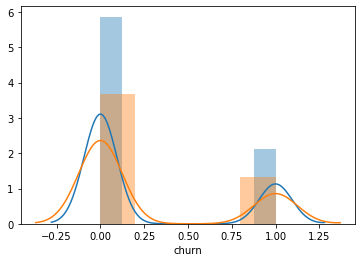

In [13]:
#Построим гистограммы и распределения признаков для тех, кто ушёл и тех, кто остался
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('churn', axis = 1)
y = df['churn']
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# гистограмма целевой переменной на train
sns.distplot(y_train);
# гистограмма целевой переменной на test
sns.distplot(y_test);

In [14]:
df.groupby('churn').agg('mean').T

churn,0,1
gender,0.511811,0.510839
loc,0.874016,0.768143
partner,0.535091,0.355325
friends,0.355015,0.183789
phone,0.903800,0.902922
contr_length,5.756248,1.728558
gr_vis,0.462855,0.268615
age,29.979459,26.989632
service,156.475817,115.082899
m_to_end_contr,5.291339,1.662582


In [15]:
#отсортируем по churn
df_go = df.query('churn ==0')
df_st = df.query('churn !=0')

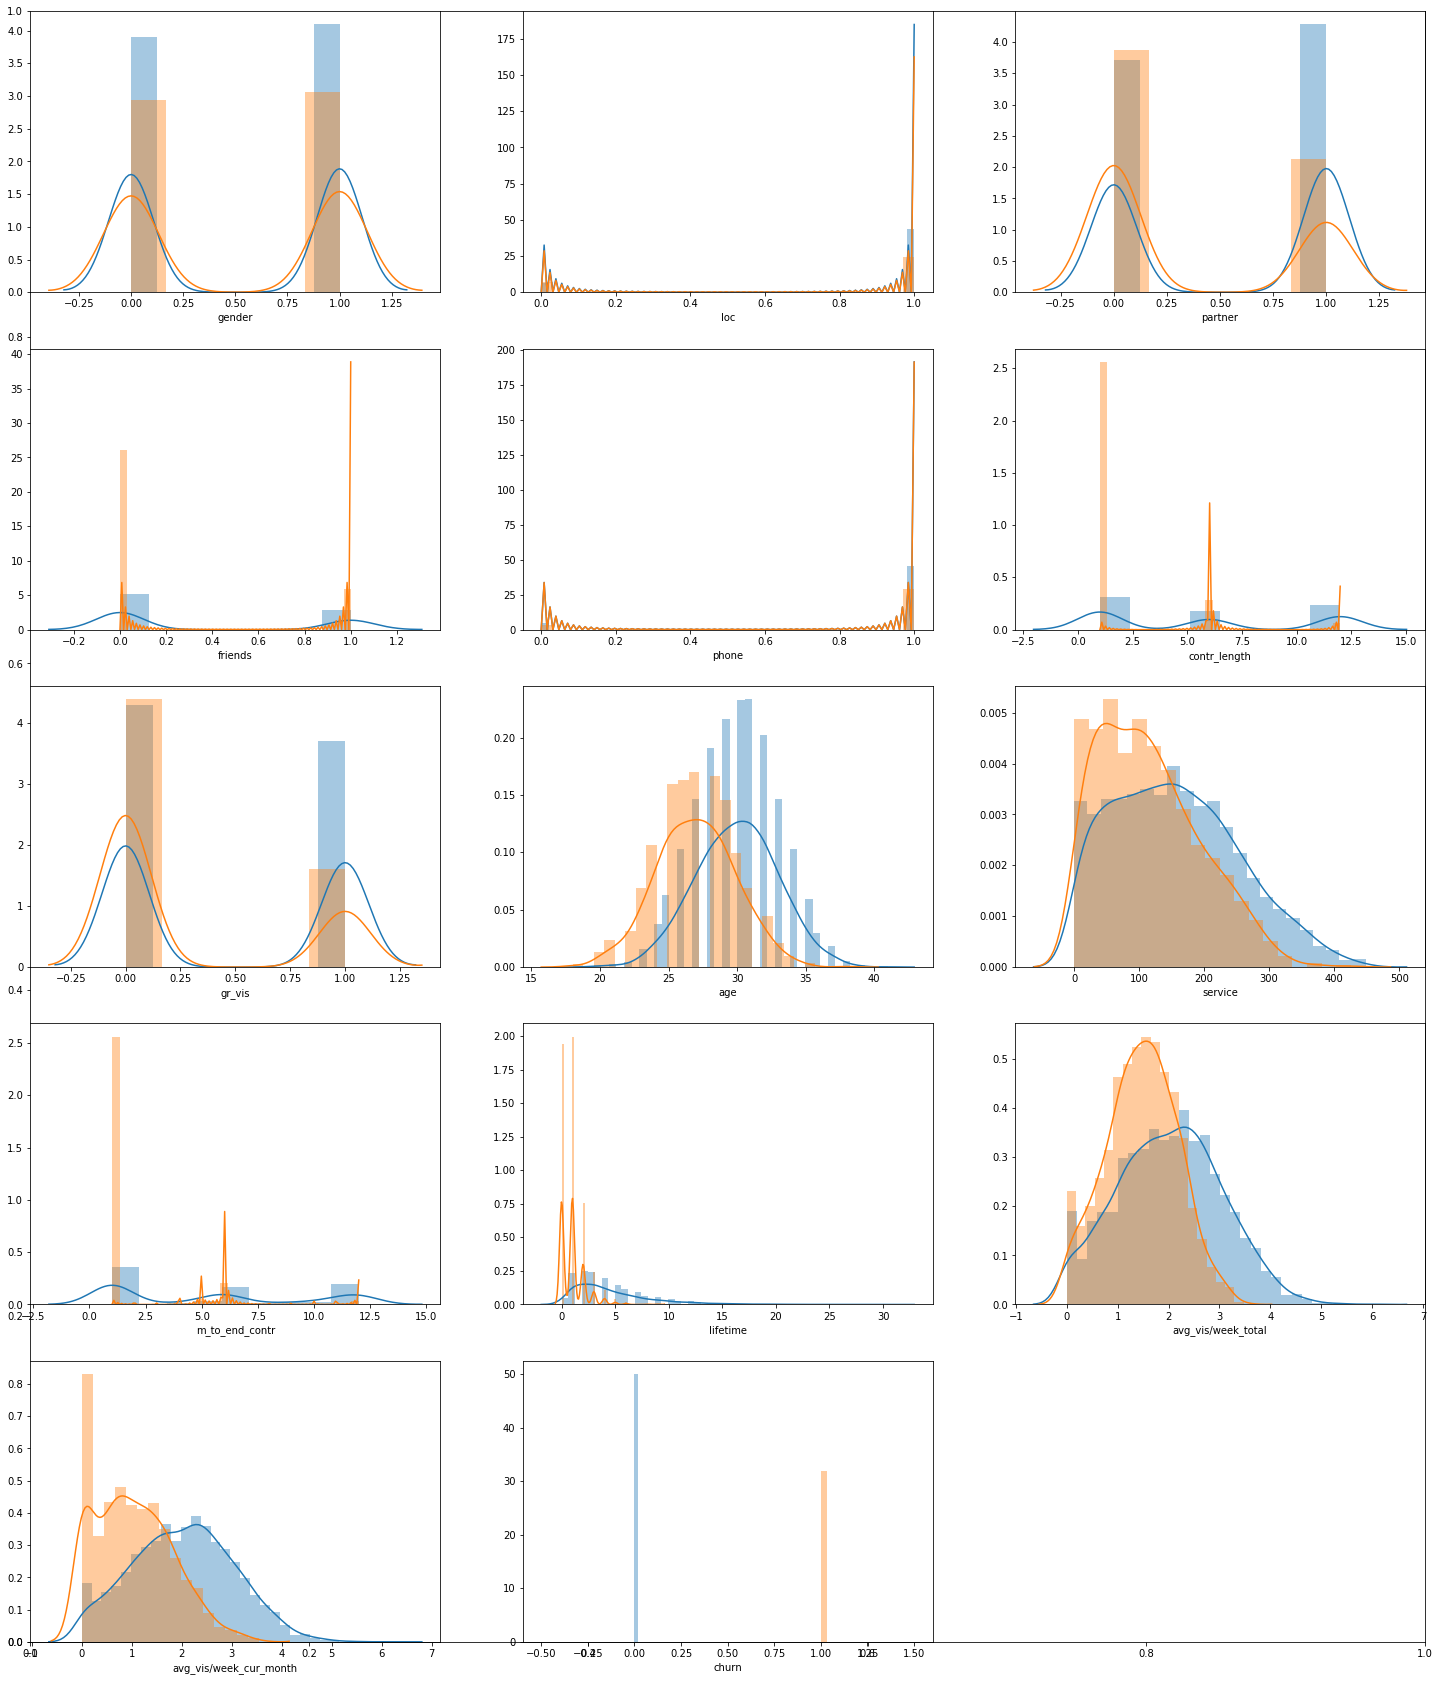

In [16]:
#построим графики
fig, ax = plt.subplots( figsize=(25,30))
k = 1
for i in df_go.columns:
    ax = fig.add_subplot(5, 3, k)
    sns.distplot(df_go[i])
    sns.distplot(df_st[i])
    k+=1
plt.show();

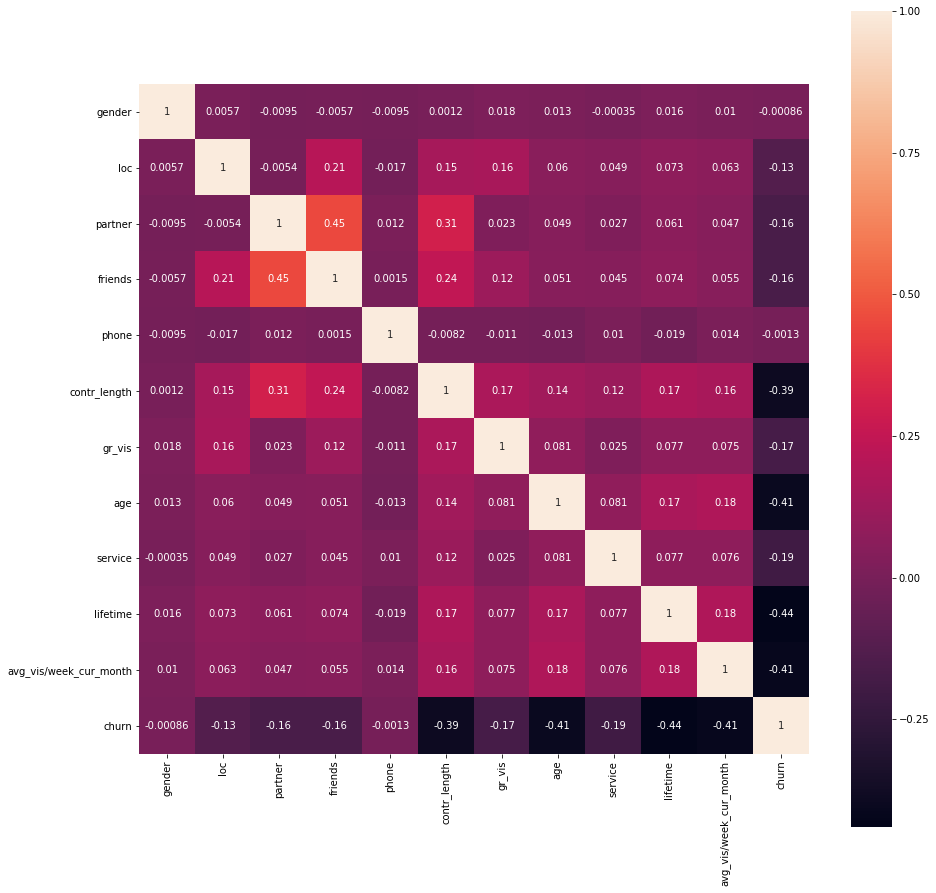

In [17]:
# убираем два сильно коррелирующих признака(на основании предыдущего вывода)
df.drop('m_to_end_contr', axis = 1, inplace = True)
df.drop('avg_vis/week_total', axis = 1, inplace = True)

#Построим матрицу корреляций и распечатаем ее
corr_m = df.corr()
plt.figure(figsize = (15,15))
sns.heatmap(corr_m, square = True, annot = True)
plt.show();

<a id='#step3'></a> 
### Модель прогнозирования оттока клиентов

In [18]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_test, y_pred)))
    

In [19]:
X = df.drop('churn', axis = 1)
y = df['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)
 
# Преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)


<b>Логистическая регрессия</b>

In [20]:
# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]
# выведем все метрики
print_all_metrics(y_test, lr_predictions,lr_probabilities, title='Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.84
	F1: 0.84
	ROC_AUC: 0.89


<b>Случайный лес</b>

In [21]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) # Ваш код здесь
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]
# выведем все метрики
print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.91
	Precision: 0.84
	Recall: 0.80
	F1: 0.82
	ROC_AUC: 0.87


<div class="alert alert-success">
<b>Комментарий ревьюера:</b>
   
Здорово, что посчитали метрику `F1`, которая как раз включает в себя основные параметры точности и полноты. 
    
В том числе рекомендую смотреть на метрику `ROC–AUC`, с точки зрения визуализации. 
    
    
Ниже статья, в которой есть материалы про метрики и как их визуализировать.
    
https://habr.com/ru/company/ods/blog/328372/
    
---

Можно также попробовать и сравнить параметр `C` у логистической регрессии. У случайного леса количество деревьев (`n_estimators`) и максимальную глубину дерева (`max_depth`), чтобы осуществить поиск лучшей модели.
    
---
    
Кстати для автоматического перебора гиперпараметров мы можем использовать готовый метод `GreadSearchCV` в библиотеке `sklearn`. 
    
</div>

<a id='#step4'></a> 
### Кластеризация клиентов

In [22]:
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)
# задаём число кластеров, равное 5, как в задании
km = KMeans(n_clusters = 5, random_state=0) 
# применяем алгоритм к данным и формируем вектор кластеров
labels = km.fit_predict(X_sc) 

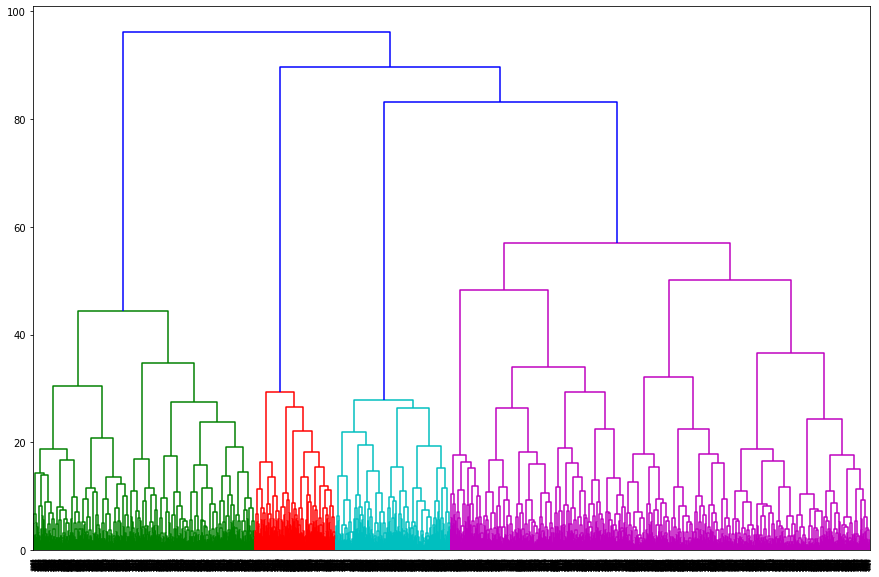

In [23]:
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show();

Исходя из цвета, можно выделить 4 кластера. Однако примем количество кластеров за 5, как сказано в задании.

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>
    
Отлично 👍

В том числе чтобы определить количество кластеров можно использовать метод локтя. 
    
Ниже статья с двумя методами, которые можно в том числе использовать для определения количества кластеров.
    
https://habr.com/ru/company/jetinfosystems/blog/467745/
    
</div>

In [24]:
# определим функцию отрисовки графиков попарных признаков для кластеров
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(10, 10))
    sns.scatterplot(df[x_name], df[y_name], hue=df[cluster_name], palette='Paired')
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show();

In [25]:
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(X_sc)
# сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = labels
#print(df)

In [26]:
#сколько клиентов в каждом кластере?
df.cluster_km.value_counts()

2    1110
3     997
1     933
4     558
0     384
Name: cluster_km, dtype: int64

In [27]:
#посмотрим на средние значения по кластерам
df.groupby('cluster_km').mean().T

cluster_km,0,1,2,3,4
gender,0.526042,0.560557,0.493694,0.486459,0.500000
loc,0.864583,1.000000,0.996396,1.000000,0.000000
partner,0.468750,0.155413,0.958559,0.277834,0.491039
friends,0.307292,0.068596,0.797297,0.121364,0.078853
phone,0.000000,1.000000,1.000000,1.000000,1.000000
contr_length,4.796875,4.226152,8.230631,2.045135,3.025090
gr_vis,0.427083,0.542337,0.519820,0.260782,0.232975
age,29.312500,30.804930,29.724324,27.284855,28.695341
service,142.458636,172.283534,155.881101,115.905248,134.657006
lifetime,3.934896,5.460879,4.316216,1.730191,3.028674


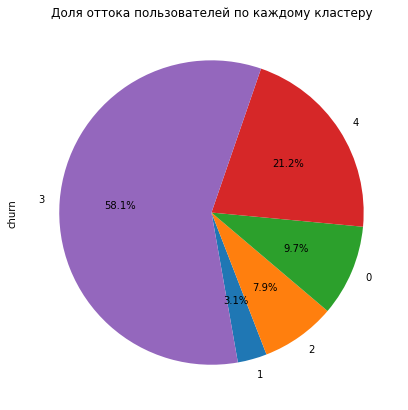

In [28]:
#посчитаем долю оттока по кластерам и построим круговую диаграмму для наглядности
df_kl = (df.groupby('cluster_km')[['churn']].sum().apply(lambda x: x/x.sum()).reset_index().sort_values('churn'))
fig = plt.figure(figsize=(7,7))
df_kl.churn.plot.pie(startangle = 280, autopct='%1.1f%%', title = 'Доля оттока пользователей по каждому кластеру');

In [29]:
print('Больше всего клиентов ушло из кластера', df_kl['cluster_km'][0:1])
print('Меньше всего клиентов ушло из кластера', df_kl['cluster_km'][4:5])

Больше всего клиентов ушло из кластера 1    1
Name: cluster_km, dtype: int64
Меньше всего клиентов ушло из кластера 3    3
Name: cluster_km, dtype: int64


<a id='#step5'></a> 
### Выводы и рекомендации по работе с клиентами

По следующим признакам можно выделить более качественные кластеры:
- более продолжительный "срок жизни"
- большая длительность абонемента
- выше расход на доп. услуги
- средняя частота посещений в неделю выше

Исходя из этих критериев более качественными и перспективными можно назвать кластеры 1 и 2, они же одни из самых многочисленных. Болше всего отказов, а также более низкие показатели по остальным критериям у кластеров 3 и 4. 

В качестве рекомендаций можно сказать следующее:
необходимо глубже проанализировать качественные кластеры, чтобы более четко составить портрет пользователя и затем рекламироваться в более узком, но целевом сегменте. Это поможет снизить затраты на рекламу за счет меньших охватов, но более качественной публики. Кроме того, продолжать поощрять качественные кластеры, как минимум сохряняя для них условия,к оторые являются для них ключевыми в выборе клуба.

Также необходимо работать с "оттекающими" кластерами. Их также стоит лучше изучить, возможно детальнее сегментировать. Провести опрос о причинах ухода, протестировать индивидуальны предложения, также стараться действовать на "опрежение", проведя опрос среди тех, кто еще не ушел, но по прогнозам собирается это сделать. 

Также стоит провести ревизию качества своих услуг, возможно дело просто в неработающем оборудовании или что-то не то с персоналом, может дополнительно обучить технике продаж и коммуникации. Это уже влияние внутренней среды клуба.

Также стоит определиться со стратегией бизнеса. Возможно не было цели сохранить посещения клиентов, а была цель лишь продать больше абонементов, но с учетом, что большинство попадет в отток. Если цель - количество абонементов, то возможно как раз стоит сконцентрироваться на аудитории, которая чаще попадает в отказ. 
Для более адресных рекомендаций нужна обратная связь от бизнеса.